In [1]:
import sys 
sys.path.append('..')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:

import os
import pytorch_lightning as pl
from src.models.multimodal.flamingo_module import FlamingoModule
from src.datasets.imageclef_dataset import ImageCLEF2021DataModule
from src.utils.utils import load_flamingo_weights, print_hyperparams

from pytorch_lightning import Trainer, seed_everything
import torchvision.transforms as T
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch

In [3]:
augmentations = {
        
        'train': T.Compose([T.Resize((224,224)),
                            T.ToTensor(),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomRotation(degrees=10),
                            T.Normalize(mean=(0.2570, 0.2570, 0.2570), std=(0.2710, 0.2710, 0.2710))
                            ]),
        'val': T.Compose([T.Resize((224,224)),
                            T.ToTensor(),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomRotation(degrees=10),
                            T.Normalize(mean=(0.2570, 0.2570, 0.2570), std=(0.2710, 0.2710, 0.2710))
                            ]),
        'test': T.Compose([T.Resize((224,224)),
                            T.ToTensor(),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomRotation(degrees=10),   
                            T.Normalize(mean=(0.2570, 0.2570, 0.2570), std=(0.2710, 0.2710, 0.2710))
                            ])
    }

    
# Hyperparameters
NUM_DATA_WORKERS  = 2
ONLY_IMAGES = False
BATCH_SIZE = 1
NUM_EPOCHS = 120
LIMIT_NUM_SAMPLES = None
DATASET = "IMAGECLEF"
LOAD_TRAINED_IMAGECLEF = True


if os.getcwd().startswith('/home/mlmi-matthias'):
    ACCELERATOR = "gpu"
    DEVICES = [6,7]
    PRETRAINED_CLIP_PATH = '/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth'
    PRETRAINED_GPT2_PATH = "/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin"
    MIMIC_CXR_DCM_PATH = '/home/mlmi-matthias/physionet.org/files/mimic-cxr/2.0.0/files/'
    MIMIC_CXR_JPG_PATH = "/home/mlmi-matthias/physionet.org/files/mimic-cxr-jpg/2.0.0/files/"
    SPLIT_PATH = '/home/mlmi-matthias/Caghan/mlmi-vqa/data/external/'
    IMAGECLEF_PATH ='/home/mlmi-matthias/imageclef/'
    #CHECKPOINT_PATH = "/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_20/checkpoints/epoch=114-val_loss=0.84-other_metric=0.00.ckpt"
    # Latest ROCO Training 
    CHECKPOINT_PATH ="/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_77/checkpoints/epoch=61-val_loss_generation_epoch=1.80.ckpt"
    ANSWERS_LIST_PATH = '/home/mlmi-matthias/Caghan/mlmi-vqa//data/external/answer_list_imageclef.txt'
    IMAGECLEF_CHECKPOINT_PATH = "/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_101/checkpoints/last.ckpt"


elif os.getcwd().startswith('/Users/caghankoksal'):
    PRETRAINED_CLIP_PATH = '/Users/caghankoksal/Desktop/development/PubMedCLIP_ViT32.pth'
    PRETRAINED_GPT2_PATH = "/Users/caghankoksal/Desktop/development/TransformerPlay/gpt2-pytorch_model.bin"
    ACCELERATOR = "cpu"
    DEVICES = 1
    MIMIC_CXR_DCM_PATH = '/Users/caghankoksal/Desktop/development/Flamingo-playground/physionet.org/files/mimic-cxr/2.0.0/files/'
    MIMIC_CXR_JPG_PATH = '/Users/caghankoksal/Desktop/development/physionet.org/files/mimic-cxr-jpg/2.0.0/files/'
    SPLIT_PATH = '/Users/caghankoksal/Desktop/SS2022/mlmi-vqa/data/external/'
    IMAGECLEF_PATH = "/Users/caghankoksal/Desktop/imageclef/"
    CHECKPOINT_PATH = "/Users/caghankoksal/Desktop/SS2022/lightning_logs/version_77/checkpoints/epoch=66-val_loss_generation_epoch=1.80.ckpt"
    ANSWERS_LIST_PATH = '/Users/caghankoksal/Desktop/SS2022/mlmi-vqa/data/external/answer_list_imageclef.txt'
    IMAGECLEF_CHECKPOINT_PATH = "/Users/caghankoksal/Desktop/SS2022/lightning_logs/version_102/checkpoints/last.ckpt"


IMAGE_TYPE = "jpg"
TOKENIZER  = "gpt2"
PREPROCESSED = True
RETURN_IDX_EOC = True

dataset_hyperparameters = {
    "root": IMAGECLEF_PATH,
    "batch_size": BATCH_SIZE,
    "tokenizer": TOKENIZER,
    "num_data_workers": NUM_DATA_WORKERS,
    "return_size": False,
    "answers_list_path": ANSWERS_LIST_PATH,
    "return_idx_answer_eoc": RETURN_IDX_EOC,
    "transforms": augmentations,
    "limit_num_samples": LIMIT_NUM_SAMPLES,
}


datamodule = ImageCLEF2021DataModule(**dataset_hyperparameters)


train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

print("Len training dataset : ", len(datamodule.train_dataset),
    "Batch Size : ", BATCH_SIZE, "NUM_EPOCHS : ",NUM_EPOCHS )
print("Total training steps : ", len(datamodule.train_dataset)//BATCH_SIZE*NUM_EPOCHS)


Len training dataset :  4500 Batch Size :  1 NUM_EPOCHS :  120
Total training steps :  540000


In [12]:
for batch in train_loader:
    cur_images = batch['image']
    print(cur_images.shape )
    cur_batch = batch
    break

torch.Size([1, 3, 224, 224])


In [13]:
cur_batch['qa_pair']

['<|endoftext|> <image> question: is this a normal gastrointestinal image? <EOQ> answer: yes <EOC>']

In [14]:
cur_batch["index_answer"]+1

tensor([15])

In [15]:
cur_batch.keys()

dict_keys(['image', 'question', 'answer', 'label', 'index_answer', 'index_eoc', 'index_eoq', 'input_ids', 'token_type_ids', 'targets', 'ID', 'qa_pair'])

In [16]:
cur_batch["input_ids"][0].shape

torch.Size([1, 128])

In [9]:
import argparse
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import pytorch_lightning as pl
from PIL import Image
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,PreTrainedTokenizerFast, GPT2Tokenizer
from PIL import Image
from tqdm import tqdm as tqdm
import torchvision.transforms as T

from src.datasets.imageclef_dataset import ImageCLEF2021DataModule
from src.models.multimodal.flamingo_module import FlamingoModule
import pytorch_lightning as pl

In [17]:
# MODEL HPRAMS
VOCAB_SIZE_OF_TOKENIZER = 50257 # mimic_datamodule.train_dataset.tokenizer.vocab_size
LANGUAGE_MODEL = 'gpt2'
NUM_TOKENS = VOCAB_SIZE_OF_TOKENIZER +4 if LANGUAGE_MODEL=="gpt2" else 31092
FLAMINGO_EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 8
ATT_HEAD_DIM = 64
CROOS_ATT_EVERY=3
MEDIA_TOKEN_ID = datamodule.train_dataset.tokenizer.\
    all_special_ids[datamodule.train_dataset.tokenizer.all_special_tokens.index('<image>')]
PERCEIVER_NUM_LATENTS = 64
PERCEIVER_DEPTH = 2
IMAGE_ENCODER = "clip"
CLASSIFICATION_MODE = True
NUM_CLASSES = 332
FLAMINGO_MODE = True
LABEL_SMOOTHING = 0.5
# Label smoothing for classification task
TOKEN_LABEL_SMOOTHING = 0.0
GRADIENT_CLIP_VAL = 1
LEARNING_RATE = 1e-4
USE_IMAGE_EMBEDDINGS = True
TRAIN_EMBEDDING_LAYER = True
CLASSIFIER_DROPOUT = 0.5


hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 30,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
    'classification_mode': CLASSIFICATION_MODE,
    'classification_num_classes': NUM_CLASSES,  # 332 if DATASET=="IMAGECLEF"
    'flamingo_mode': FLAMINGO_MODE,
    "label_smoothing": LABEL_SMOOTHING,
    "token_label_smoothing": TOKEN_LABEL_SMOOTHING,
    "learning_rate":LEARNING_RATE,
    "use_image_embeddings": USE_IMAGE_EMBEDDINGS,
    "train_embedding_layer": TRAIN_EMBEDDING_LAYER,
    "classifier_dropout": CLASSIFIER_DROPOUT
    }

print_hyperparams(hyperparams)

model = FlamingoModule(**hyperparams)
START_FROM_CHECKPOINT = True

if START_FROM_CHECKPOINT:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",CHECKPOINT_PATH)
    if os.getcwd().startswith('/home/mlmi-matthias'):
        model.load_state_dict(torch.load(CHECKPOINT_PATH)["state_dict"],strict=False)
    else:
        model.load_state_dict(torch.load(CHECKPOINT_PATH,map_location=torch.device('cpu'))["state_dict"],strict=False)

pretrained_clip_path /Users/caghankoksal/Desktop/development/PubMedCLIP_ViT32.pth
warmup_steps 30
num_tokens 50261
dim 768
depth 12
num_heads 8
dim_head 64
cross_attn_every 3
media_token_id 50258
perceiver_num_latents 64
perceiver_depth 2
image_encoder clip
language_model gpt2
pretrained_gpt2_path /Users/caghankoksal/Desktop/development/TransformerPlay/gpt2-pytorch_model.bin
classification_mode True
classification_num_classes 332
flamingo_mode True
label_smoothing 0.5
token_label_smoothing 0.0
learning_rate 0.0001
use_image_embeddings True
train_embedding_layer True
classifier_dropout 0.5
Clip architecture is being loaded
Clip pretrained weights are being loaded
Flamingo is being initialized with  gpt2  as language model
GPT 2 Weights are loading...
Loaded GPT2 weights and Embeddings num_weights loaded :  156
Pretrained Flamingo Model is loaded from checkpoint :  /Users/caghankoksal/Desktop/SS2022/lightning_logs/version_77/checkpoints/epoch=66-val_loss_generation_epoch=1.80.ckpt


FileNotFoundError: [Errno 2] No such file or directory: '/Users/caghankoksal/Desktop/SS2022/lightning_logs/version_77/checkpoints/epoch=66-val_loss_generation_epoch=1.80.ckpt'

In [18]:
!ls "/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/"

ls: /home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/: No such file or directory


In [19]:
!pwd

/Users/caghankoksal/Desktop/SS2022/mlmi-vqa/notebooks


In [20]:

#IMAGECLEF_CHECKPOINT_PATH ='/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_95/checkpoints/\
#epoch=94-val_acc_epoch=0.41-val_total_loss_epoch=4.28-val_loss_generation_epoch=0.22-val_classification_loss_epoch=4.06.ckpt'
#IMAGECLEF_CHECKPOINT_PATH = "/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_99/checkpoints/epoch=82-val_acc_epoch=0.39-val_total_loss_epoch=5.28-val_loss_generation_epoch=0.23-val_classification_loss_epoch=5.05.ckpt"
IMAGECLEF_CHECKPOINT_PATH = "/home/mlmi-matthias/Caghan/mlmi-vqa/notebooks/lightning_logs/version_108/checkpoints/epoch=22-val_loss_generation_epoch=0.21.ckpt"
IMAGECLEF_CHECKPOINT_PATH = "/Users/caghankoksal/Desktop/SS2022/lightning_logs/version_108/checkpoints/last.ckpt"
IMAGECLEF_CHECKPOINT_PATH = "/Users/caghankoksal/Desktop/SS2022/lightning_logs/version_110/checkpoints/last.ckpt"

In [21]:
if LOAD_TRAINED_IMAGECLEF:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",IMAGECLEF_CHECKPOINT_PATH)
    if os.getcwd().startswith('/home/mlmi-matthias'):
        model.load_state_dict(torch.load(IMAGECLEF_CHECKPOINT_PATH)["state_dict"],strict=False)
    else:
        model.load_state_dict(torch.load(IMAGECLEF_CHECKPOINT_PATH,map_location=torch.device('cpu'))["state_dict"],strict=False)
        print("Checkpoint Weights are loaded")

Pretrained Flamingo Model is loaded from checkpoint :  /Users/caghankoksal/Desktop/SS2022/lightning_logs/version_110/checkpoints/last.ckpt
Checkpoint Weights are loaded


In [22]:
#torch.load(IMAGECLEF_CHECKPOINT_PATH,map_location=torch.device('cpu'))["hyper_parameters"]

In [23]:

model.eval()

FlamingoModule(
  (flamingo_palm): FlamingoModel(
    (token_emb): Embedding(50261, 768)
    (wpe): Embedding(256, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (img_encoder): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    

val_img = imageclef_datamodule.val_dataset[3]["image"]
val_qa_pair= imageclef_datamodule.val_dataset[3]["qa_pair"]
val_qa_pair.split('answer')
val_question =  imageclef_datamodule.val_dataset[3]["question"]
val_question


In [24]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from transformers import GPT2Tokenizer
import numpy as np

from torch import nn as nn
import torch.nn.functional as F
def generate(image, context, cur_model, batch, ntok=20):
    for _ in range(ntok):
        out,_ = cur_model({'image': image,'input_ids': context, "index_eoq": batch["index_eoq"],
        "targets": batch["targets"],"label": batch["label"]})
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        #next_tok1 = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        #print(next_tok1.shape)
        softmax_out = F.softmax(logits, dim=-1)
        #print(softmax_out.shape)
        next_tok = torch.argmax(softmax_out,dim=-1,keepdim=False)
        #print(next_tok.shape)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context


tokenizer = datamodule.train_dataset.tokenizer

In [25]:
val_dataloader = datamodule.val_dataloader()

In [26]:
len(val_dataloader)

500

In [27]:
val_loader_iter = iter(val_dataloader)

In [28]:
#batch = next(val_loader_iter)

In [34]:
batch["question"][0]

'what is the primary abnormality in this image?'

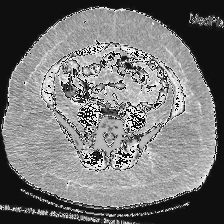

In [33]:
T.ToPILImage()(batch["image"][0])

In [32]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Question : ", batch["question"][0])
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Question :  what is the primary abnormality in this image?
Model's answer :   acute appendicitis 
Correct Answer: acute appendicitis


In [30]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   acute appendicitis 
Correct Answer: acute appendicitis


In [46]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   pheochromocytoma 
Correct Answer: pheochromocytoma


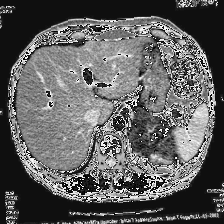

In [49]:
T.ToPILImage()(batch["image"][0])

In [ ]:
context   = torch.tensor([tokenizer.encode(
    "<|endoftext|> <image> question: There is a pheochromocytoma in this image. Why there is a pheochromocytoma "+\
            ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)

In [36]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   incidental hepatic artery aneurysm 
Correct Answer: renal cell carcinoma


In [37]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   focal nodular hyperplasia 
Correct Answer: renal arteriovenous malformation


In [38]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   adenocarcinoma of the gastroesophageal junction 
Correct Answer: pericardial cyst


In [39]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   acute appendicitis 
Correct Answer: acute appendicitis


In [40]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   right aortic arch with aberrant right subclavian artery 
Correct Answer: neurofibromatosis-1, nf1, nf-1


In [41]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   pheochromocytoma 
Correct Answer: adrenal adenoma


In [42]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   osteomyelitis 
Correct Answer: cavernous hemangioma


In [43]:
batch = next(val_loader_iter)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
out = generate(batch["image"], context, model, batch, ntok=20)
print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
print("Correct Answer: " + batch["answer"][0])

Model's answer :   pulmonary embolism 
Correct Answer: liver hemangioma


In [44]:
def calculate_accuracy_classification_task(dataloader, model):
    # Calculate accuracy as a classification task
    true_count = 0
    for batch in tqdm(dataloader):
        flamingo_logits, classification_logits = model(batch)
        true_label = batch["label"]
        pred = torch.argmax(classification_logits,dim=1).item() 
        #print("Prediction is : ",pred)

        if pred == true_label:
            #print("true prediction")
            true_count +=1
    print("Accuracy of the model on the classification task is ", true_count/len(dataloader) )
    return true_count/len(dataloader)


In [45]:
calculate_accuracy_classification_task(val_dataloader,model=model)

 

100%|██████████| 500/500 [01:18<00:00,  6.38it/s]

Accuracy of the model on the classification task is  0.0


0.0

In [42]:
correct = 0
val_dataloader = datamodule.val_dataloader()
tokenizer = datamodule.train_dataset.tokenizer
true_predictions = []
false_predictions = []
for batch in tqdm(val_dataloader):
    #batch = next(val_loader_iter)
    context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
    out = generate(batch["image"], context, model, batch, ntok=20)
    models_answer = tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0].rstrip().strip()
    correct_answer = batch["answer"][0].rstrip().strip()
    if models_answer == correct_answer:
        correct += 1
        true_predictions.append((models_answer, correct_answer))
    else:
        false_predictions.append((models_answer, correct_answer))

    

100%|██████████| 500/500 [17:36<00:00,  2.11s/it]


In [43]:
correct/len(val_dataloader)



0.2

In [44]:
correct

100

In [45]:
TRUE_PREDS_FILE_NAME = 'correct_predictions_FT_ROCO_FlamingoModeON_ckpt_110.xlsx'
FALSE_PREDS_FILE_NAME = "false_predictions_FT_ROCO_FlamingoModeON_ckpt_110.xlsx"

In [46]:
import pandas as pd

correct_preds_pred = pd.DataFrame(true_predictions, columns=["models_answer","correct_answer"])

In [47]:
correct_preds_pred.to_excel(TRUE_PREDS_FILE_NAME)

In [48]:
false_preds_pred = pd.DataFrame(false_predictions, columns=["models_answer","correct_answer"])
false_preds_pred.to_excel(FALSE_PREDS_FILE_NAME)

In [49]:
concat_list = pd.concat([correct_preds_pred, false_preds_pred], axis=0).reset_index().drop(columns=['index'])

In [50]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
def calculate_bleu_score():
  bleu_per_answer = np.asarray( [ sentence_bleu(target.split(), pred.split(), weights = [1])  for pred, target in zip(concat_list["models_answer"],concat_list["correct_answer"])  ])
  return np.mean(bleu_per_answer)

cur_bleu = 0
for pred, target in zip(concat_list["models_answer"],concat_list["correct_answer"]):
    try:
        cur_bleu += sentence_bleu( [target.split()], pred.split(), weights = [1])
    except:
        print(pred, target)

cur_bleu/len(concat_list["models_answer"])

0.23471396475351208

In [ ]:
# BEAM SEARCH DECODER 

In [ ]:
from src.utils.utils import beam_decode

In [ ]:
decoded_outs = beam_decode(cur_batch, model, tokenizer, top_k=2, beam_width=2, max_len=100)

In [ ]:
decoded_outs[0][-1][0]

In [ ]:
for each in decoded_outs[0][0]:
    #print(each)
    print(tokenizer.decode(each[0]))

In [ ]:
dataset_params = {
    "root": "/Users/caghankoksal/Desktop/imageclef/",
    "batch_size": 1,
    "tokenizer": "gpt2",
    "return_size": False,
    "num_data_workers": 0,
    "limit_num_samples" : None
}
imageclef_datamodule = ImageCLEF2021DataModule(**dataset_params,transforms=augmentations)


In [ ]:
VOCAB_SIZE_OF_TOKENIZER = 50257 # mimic_datamodule.train_dataset.tokenizer.vocab_size
LANGUAGE_MODEL = 'gpt2'
NUM_TOKENS = VOCAB_SIZE_OF_TOKENIZER +3 if LANGUAGE_MODEL=="gpt2" else 31092
FLAMINGO_EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 8
ATT_HEAD_DIM = 64
CROOS_ATT_EVERY=3
MEDIA_TOKEN_ID = imageclef_datamodule.train_dataset.tokenizer.all_special_ids[imageclef_datamodule.train_dataset.tokenizer.all_special_tokens.index('<image>')]
PERCEIVER_NUM_LATENTS = 64
PERCEIVER_DEPTH = 2
IMAGE_ENCODER = "clip"
PRETRAINED_CLIP_PATH = '/Users/caghankoksal/Desktop/development/PubMedCLIP_ViT32.pth'
PRETRAINED_GPT2_PATH = "/Users/caghankoksal/Desktop/development/TransformerPlay/gpt2-pytorch_model.bin"

model_hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 569,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
}

for k,v in model_hyperparams.items():
    print(f"{k}: {v}")
model = FlamingoModule(**model_hyperparams)
#CHECKPOINT_PATH = "/Users/caghankoksal/Desktop/SS2022/lightning_logs/version_23/checkpoints/epoch=34-val_loss=0.25-other_metric=0.00.ckpt"
# Pretrained on ROCO FineTuning on ImageCLEF 2021
CHECKPOINT_PATH = "/Users/caghankoksal/Desktop/SS2022/lightning_logs/version_31/checkpoints/epoch=28-val_loss=0.23-other_metric=0.00.ckpt"
model.load_state_dict(torch.load(CHECKPOINT_PATH,map_location=torch.device('cpu'))["state_dict"])
model.eval()
    

In [ ]:
val_dataloader = imageclef_datamodule.val_dataloader()
val_loader_iter = iter(val_dataloader)
tokenizer = imageclef_datamodule.train_dataset.tokenizer

In [ ]:
batch = next(val_loader_iter)
#batch = next(val_loader_iter)
out = beam_decode(batch,model)

models_answer = tokenizer.decode(out[0][-1][0][0]).split('answer:')[1].split('<EOC>')[0].rstrip().strip()
correct_answer = batch["answer"][0].rstrip().strip()

In [ ]:
models_answer,correct_answer

In [ ]:
# INFERENCE BEAM SEARCH



correct = 0
val_dataloader = imageclef_datamodule.val_dataloader()
tokenizer = imageclef_datamodule.train_dataset.tokenizer
true_predictions = []
false_predictions = []
for batch in tqdm(val_dataloader):
    #batch = next(val_loader_iter)
    out = beam_decode(batch,model,top_k=2,beam_width=2,max_len=100)

    models_answer = tokenizer.decode(out[0][-1][0][0]).split('answer:')[1].split('<EOC>')[0].rstrip().strip()
    correct_answer = batch["answer"][0].rstrip().strip()
    if models_answer == correct_answer:
        correct += 1
        true_predictions.append((models_answer, correct_answer))
    else:
        false_predictions.append((models_answer, correct_answer))

    

In [ ]:
correct/len(val_dataloader)

In [ ]:
false_predictions[1]

In [ ]:
import pandas as pd
questions = [ batch["question"] for batch  in imageclef_datamodule.val_dataloader() ]
correct_preds_pred = pd.DataFrame(true_predictions, columns=["models_answer","correct_answer"])
false_preds_pred = pd.DataFrame(false_predictions, columns=["models_answer","correct_answer"])
questions = pd.DataFrame(questions, columns=["question"])

In [ ]:
true_false_col = pd.DataFrame([ "True"  if i <len(correct_preds_pred) else "False"  for  i in range(len(questions)) ], columns=["True/False"])

In [ ]:


concat_list = pd.concat([ correct_preds_pred, false_preds_pred], axis=0).reset_index().drop(columns=["index"])
concat_list = pd.concat([questions,concat_list, true_false_col], axis=1)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np



cur_bleu = 0
for pred, target in zip(concat_list["models_answer"],concat_list["correct_answer"]):
    try:
        cur_bleu += sentence_bleu( [target.split()], pred.split(), weights = [1])
    except:
        print(pred, target)

cur_bleu/len(concat_list["models_answer"])

In [ ]:
concat_list.to_excel("../reports/predictions_all_imageclef_version31_roco_beam_decode_blue_0.1766_width_2_top_k_1_.xlsx")

In [51]:
# First, install Gradio
!pip install --quiet gradio

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    Normalize(mean=(0.257, 0.257, 0.257), std=(0.271, 0.271, 0.271))
)

In [13]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from transformers import GPT2Tokenizer
import numpy as np

from torch import nn as nn
import torch.nn.functional as F
def generate_gradio(image, context, cur_model, ntok=20):
    for _ in range(ntok):
        out= cur_model({'image': image,'input_ids': context})
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        #next_tok1 = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        #print(next_tok1.shape)
        softmax_out = F.softmax(logits, dim=-1)
        #print(softmax_out.shape)
        next_tok = torch.argmax(softmax_out,dim=-1,keepdim=False)
        #print(next_tok.shape)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context


tokenizer = datamodule.train_dataset.tokenizer

In [14]:
def predict_gradio(image, question):
    print("Input question")
    process_img = augmentations["val"](image).unsqueeze(0)
    print("Process_img succesfull")
    context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+question + ' <EOQ>'+ ' answer:')]) 
    out = generate_gradio( process_img,context, model, ntok=20)
    #print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
    result = tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0]
    return result

    

In [15]:
question = "What is the current disease"
read_im = Image.open("synpic16279.jpg")
process_img = augmentations["val"](read_im).unsqueeze(0)
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+question + ' <EOQ>'+ ' answer:')]) 
out = generate_gradio( process_img,context, model,20)
    #print("Model's answer : ",tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0])
result = tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0]



FileNotFoundError: [Errno 2] No such file or directory: 'synpic16279.jpg'

In [16]:
hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 30,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
    'classification_mode': False,
    'classification_num_classes': NUM_CLASSES,  # 332 if DATASET=="IMAGECLEF"
    'flamingo_mode': FLAMINGO_MODE,
    "label_smoothing": LABEL_SMOOTHING,
    "token_label_smoothing": TOKEN_LABEL_SMOOTHING,
    "learning_rate":LEARNING_RATE,
    "use_image_embeddings": USE_IMAGE_EMBEDDINGS,
    "train_embedding_layer": TRAIN_EMBEDDING_LAYER,
    "classifier_dropout": CLASSIFIER_DROPOUT
    }

print_hyperparams(hyperparams)

model = FlamingoModule(**hyperparams)

pretrained_clip_path /Users/caghankoksal/Desktop/development/PubMedCLIP_ViT32.pth
warmup_steps 30
num_tokens 50261
dim 768
depth 12
num_heads 8
dim_head 64
cross_attn_every 3
media_token_id 50258
perceiver_num_latents 64
perceiver_depth 2
image_encoder clip
language_model gpt2
pretrained_gpt2_path /Users/caghankoksal/Desktop/development/TransformerPlay/gpt2-pytorch_model.bin
classification_mode False
classification_num_classes 332
flamingo_mode True
label_smoothing 0.5
token_label_smoothing 0.0
learning_rate 0.0001
use_image_embeddings True
train_embedding_layer True
classifier_dropout 0.5
Clip architecture is being loaded
Clip pretrained weights are being loaded
Flamingo is being initialized with  gpt2  as language model
GPT 2 Weights are loading...
Loaded GPT2 weights and Embeddings num_weights loaded :  156


In [17]:
if LOAD_TRAINED_IMAGECLEF:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",IMAGECLEF_CHECKPOINT_PATH)
    if os.getcwd().startswith('/home/mlmi-matthias'):
        model.load_state_dict(torch.load(IMAGECLEF_CHECKPOINT_PATH)["state_dict"],strict=False)
    else:
        model.load_state_dict(torch.load(IMAGECLEF_CHECKPOINT_PATH,map_location=torch.device('cpu'))["state_dict"],strict=False)
        print("Checkpoint Weights are loaded")

Pretrained Flamingo Model is loaded from checkpoint :  /Users/caghankoksal/Desktop/SS2022/lightning_logs/version_102/checkpoints/last.ckpt
Checkpoint Weights are loaded


In [18]:
import gradio as gr




title = "Visual_Question_Answering on Medical Data ImageCLEF"
description = "Gradio Demo for Medical Visual_Question_Answering. Upload your own image (high-resolution images are recommended) or click any one of the examples, and click " \
              "\"Submit\" and then wait for our's answer. "
article = "<p style='text-align: center'><a href='https://github.com/OFA-Sys/OFA' target='_blank'>OFA Github " \
          "Repo</a></p> "
examples = [['demo_images/synpic16279.jpg','what is abnormal in the x-ray?' ], ['demo_images/synpic17959.jpg',  'what is most alarming about this mri?']]
io = gr.Interface(fn=predict_gradio, inputs=[gr.inputs.Image(type='pil'), "textbox"], outputs=gr.outputs.Textbox(label="Answer"),
                 examples=examples,title=title, description=description,
                  debug=True)
io.launch(share=True)

Running on local URL:  http://127.0.0.1:7860/


INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.6p1)
INFO:paramiko.transport:Authentication (publickey) successful!


Running on public URL: https://22030.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x2a5d9f9d0>,
 'http://127.0.0.1:7860/',
 'https://22030.gradio.app')

In [ ]:
import gradio as gr

def calculator(num1, operation, num2):
    if operation == "add":
        return num1 + num2
    elif operation == "subtract":
        return num1 - num2
    elif operation == "multiply":
        return num1 * num2
    elif operation == "divide":
        return num1 / num2


demo = gr.Interface(
    fn=calculator,
    inputs=[
            gr.Number(value=4), 
            gr.Radio(["add", "subtract", "multiply", "divide"]), 
            "number"
            ],
    outputs="number",
    examples=[
        [5, "add", 3],
        [4, "divide", 2],
        [-4, "multiply", 2.5],
        [0, "subtract", 1.2],
    ],
    title="test calculator",
    description="heres a sample **toy calculator**. enjoy!",
)

demo.launch(share=True)

